In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from collections import defaultdict

In [3]:
def load_and_preprocess(fname):
    gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    blurred_cropped = blurred[600:, :]
    (T, threshinv) = cv2.threshold(blurred_cropped, 200, 255, cv2.THRESH_BINARY_INV)
    return threshinv

In [4]:
def slope_close_to(theta, theta_0, tol=5):
    # theta - rad
    # theta_0 - deg
    # tol - deg
    # deg angles range from [-90,90], theta is converted to this scale
    theta_1 = (180/np.pi)*theta.copy()
    theta_1[theta_1>90] = theta_1[theta_1>90]-180
    return np.isclose(theta_1, theta_0, atol=tol)

In [5]:
def merge_lines(lines, ro_tol=2):
    # lines: nx2 matrix, first column is ro and second column is theta
    # parallel lines
    # keeps the left most line
    # returns a mask that works on sorted lines on ro
    
    sorted_ros = lines[:,0]
    
    mask = np.zeros(lines.shape[0], dtype=np.bool8)
    
    if len(lines) == 0:
        return mask

    mask[0] = True
    prev_ro = sorted_ros[0]
    
    for i,ro in enumerate(sorted_ros[1:]):
        i+=1
        if np.isclose(ro, prev_ro, atol=ro_tol):
            continue
        else:
            mask[i] = True
            prev_ro = ro
            
    return mask

In [12]:
def get_vertical_lines(img):
    lines = np.abs(cv2.HoughLines(img,1/4,np.pi/(4*180),300).squeeze())
    sorted_lines = lines[np.argsort(lines[:,0])]
    vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
    vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, ro_tol=10)]
    return vertical_lines_merged

In [32]:
def patches(img, vertical_lines, stack, sub_stack, col=None):
    y1,y2 = 0,img.shape[0]
    
    if sub_stack == 0:
        x1= 0 if stack==0 else int(vertical_lines[22*stack-1,0])
        x2=int(vertical_lines[22*stack,0])
    elif sub_stack == 1:
        x1=int(vertical_lines[22*stack,0])
        x2=int(vertical_lines[22*stack+2,0])
    else:
        if col is None:
            x1=int(vertical_lines[22*stack+2,0])
            x2=int(vertical_lines[22*stack+21,0])
        else:
            x1=int(vertical_lines[22*stack+2+4*col,0])
            x2=int(vertical_lines[22*stack+2+4*col+3,0])
    
    # print(x1,x2,y1,y2)
    return img[y1:y2, x1:x2]

In [9]:
def connected_components(data):
    labels = np.zeros_like(data).astype(np.uint64)
    n = 0
    for i in range(len(data[1:])):
        left = data[i-1]
        if data[i] != 0:
            if left == 0:
                n += 1
                labels[i] = n
            else:
                labels[i] = n
            
    return labels

In [34]:
def segment(p, min_width=25, min_intensity=180):
    data = np.sum(p, axis=1)/p.shape[1]
    data_thresh = data.copy()
    data_thresh[data_thresh<20] = 0
    cc = connected_components(data_thresh)
    
    # remove components with width less than min_width
    labels = set(np.unique(cc))-{0}
    for c in labels:
        if cc[cc==c].shape[0] < 20:
            cc[cc==c] = 0
            
    labels = set(np.unique(cc))-{0}
    
    # calculate average intensity of each component
    avg_intensity = np.zeros(len(labels))
    for i,c in enumerate(labels):
        avg_intensity[i] = np.mean(data_thresh[cc==c])
    
    # map components with intensity less than min_intensity as 0 (unfilled) otherwise 1 (filled)
    return [1 if i > min_intensity else 0 for i in avg_intensity]
    

In [52]:
img = load_and_preprocess('../test-images/a-3.jpg')
vertical_lines = get_vertical_lines(img)

In [66]:
answers = defaultdict(list)
for stack in [0,1,2]:
    for col in [0,1,2,3,4]:
        p = patches(img, vertical_lines, stack=stack, sub_stack=2, col=col)
        qnum_start = 29*stack
        filled = segment(p, min_width=25, min_intensity=180)
        print(stack, col, len(filled))
        for i,f in enumerate(filled):
            if f==1:
                q_num = qnum_start + i + 1
                answers[q_num].append(col)

0 0 29
0 1 29
0 2 29
0 3 29
0 4 29
1 0 29
1 1 29
1 2 29
1 3 29
1 4 29
2 0 27
0
2 1 27
2 2 27
2
2 3 27
2 4 27


In [54]:
answers_str = [f'{i} {"".join([chr(ord("A")+a) for a in anss])}' for i, anss in sorted(answers.items())]

In [55]:
with open('a-3_results.txt', 'w') as f:
    f.write('\n'.join(answers_str))

In [65]:
segment(p, min_width=25, min_intensity=180)

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

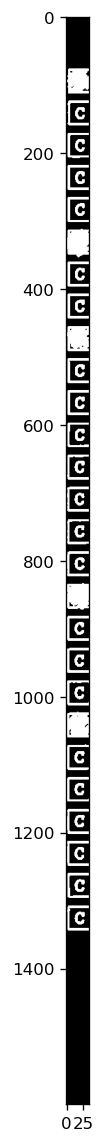

In [64]:
p = patches(img, vertical_lines, stack=2, sub_stack=2, col=2)
plt.figure(figsize=(10,12))
plt.imshow(p, cmap='gray')

In [20]:
segment(p, min_width=25, min_intensity=180)

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0]

In [22]:
x={}
x[(1,2)]=3